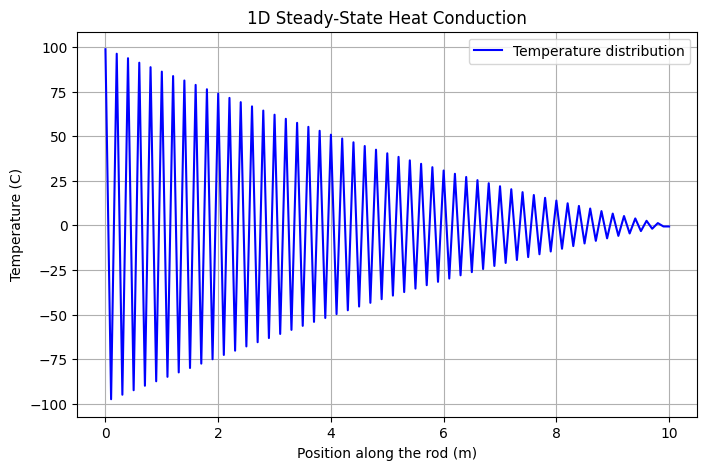

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def thermal_conductivity(x):
    """Thermal conductivity function k(x) = 1 + 0.01 * x^2"""
    return 1 + 0.01 * x**2

def tdma_solver(a, b, c, d):
    """Solve the system of linear equations using the TDMA method.
    a, b, c are the sub-diagonal, main diagonal, and super-diagonal coefficients.
    d is the right-hand side vector."""
    n = len(d)
    cp = np.zeros(n)
    dp = np.zeros(n)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]

    for i in range(1, n):
        denominator = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denominator
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denominator

    x = np.zeros(n)
    x[-1] = dp[-1]

    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x

# Problem parameters
length = 10.0  # Length of the rod (m)
nx = 100       # Number of control volumes
dx = length / nx  # Width of each control volume

# Boundary conditions
T_left = 100.0  # Fixed temperature at the left end (C)
q_right = 1.0   # Heat flux at the right end (W/m^2)

# Set up the grid
x = np.linspace(0, length, nx + 1)  # Node positions (includes boundaries)
x_centers = (x[:-1] + x[1:]) / 2    # Cell center positions

# Coefficients for the TDMA solver
a = np.zeros(nx)
b = np.zeros(nx)
c = np.zeros(nx)
d = np.zeros(nx)

for i in range(nx):
    k_w = thermal_conductivity(x_centers[i] - dx / 2)
    k_e = thermal_conductivity(x_centers[i] + dx / 2)

    a[i] = k_w / dx  # Coefficient for T_{i-1}
    c[i] = k_e / dx  # Coefficient for T_{i+1}
    b[i] = a[i] + c[i]  # Coefficient for T_{i}

# Right-hand side vector
d[0] = T_left * a[0]  # Include boundary condition at x = 0
for i in range(1, nx):
    d[i] = 0

# Adjust coefficients for boundary conditions
a[0] = 0  # No T_{-1} at the left boundary
c[-1] = 0  # No T_{N+1} at the right boundary
b[-1] += dx / thermal_conductivity(x_centers[-1])  # Account for heat flux boundary

d[-1] += q_right * dx  # Add heat flux contribution to the last cell

# Solve the system
T = tdma_solver(a, b, c, d)

# Add the left boundary temperature to the solution
T_full = np.zeros(nx + 1)
T_full[:-1] = T
T_full[-1] = T[-1]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(x, T_full, label="Temperature distribution", color="blue")
plt.xlabel("Position along the rod (m)")
plt.ylabel("Temperature (C)")
plt.title("1D Steady-State Heat Conduction")
plt.grid(True)
plt.legend()
plt.show()


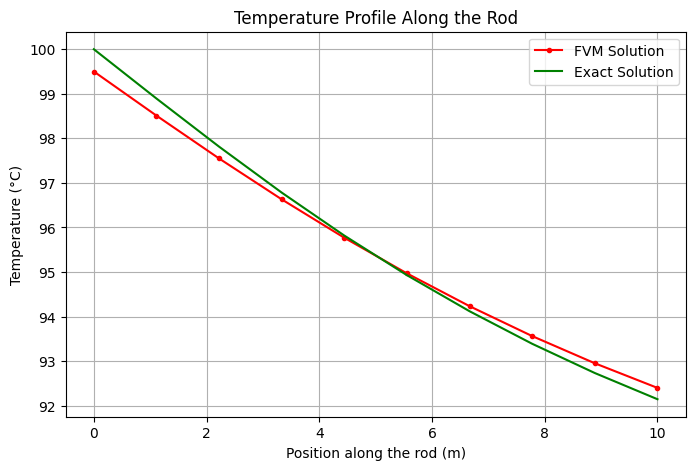

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Problem setup
x_start, x_finish = 0.0, 10.0  # Domain boundaries
lx = x_finish - x_start        # Length of the rod
nx = 10                        # Number of finite volumes
Ta = 100.0                     # Fixed temperature at the left end
Qb = 1.0                       # Heat flux at the right end
dx = lx / nx                   # Distance between nodes

# Function for varying thermal conductivity
def K(x):
    return 1 + 0.01 * x**2

# West-face thermal conductivity
def kw(n):
    return K(x_start + (n - 1) * dx)

# East-face thermal conductivity
def ke(n):
    return K(x_start + n * dx)

# Coefficients for the discretized equation
def aw(n):
    if n == 1:
        return 0.0
    return kw(n)

def ap(n):
    if n == 1:
        return -(2 * kw(1) + ke(1))
    elif n == nx:
        return -kw(n)
    return -(kw(n) + ke(n))

def ae(n):
    if n == nx:
        return 0.0
    return ke(n)

def S(n):
    if n == 1:
        return -2 * kw(1) * Ta
    elif n == nx:
        return Qb * dx
    return 0.0

# Forming the tri-diagonal matrix
a_w = np.array([aw(n) for n in range(1, nx + 1)])
a_p = np.array([ap(n) for n in range(1, nx + 1)])
a_e = np.array([ae(n) for n in range(1, nx + 1)])
S_vec = np.array([S(n) for n in range(1, nx + 1)])

# Initialize TDM (Tri-Diagonal Matrix)
Tdm = np.zeros((nx, 4))  # Columns: a_w, a_p, a_e, S
Tdm[:, 0] = a_w  # West coefficients
Tdm[:, 1] = a_p  # Main diagonal
Tdm[:, 2] = a_e  # East coefficients
Tdm[:, 3] = S_vec  # Source term

# TDMA forward elimination
for i in range(1, nx):
    factor = Tdm[i, 0] / Tdm[i - 1, 1]
    Tdm[i, 1] -= factor * Tdm[i - 1, 2]
    Tdm[i, 3] -= factor * Tdm[i - 1, 3]

# Back substitution
T = np.zeros(nx)
T[-1] = Tdm[-1, 3] / Tdm[-1, 1]
for i in range(nx - 2, -1, -1):
    T[i] = (Tdm[i, 3] - Tdm[i, 2] * T[i + 1]) / Tdm[i, 1]

# Exact solution (analytical)
xx = np.linspace(x_start, x_finish, nx)
exact_T = 100 - 10 * np.arctan(0.1 * xx)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(xx, T, 'r.-', label='FVM Solution')
plt.plot(xx, exact_T, 'g-', label='Exact Solution')
plt.title("Temperature Profile Along the Rod")
plt.xlabel("Position along the rod (m)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
plt.show()


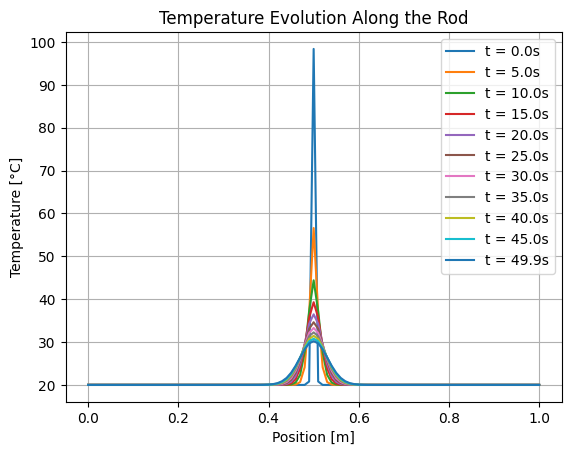

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
L = 1.0             # Length of the rod [m]
T_center = 100.0    # Initial center temperature [°C]
T_ambient = 20.0    # Initial and boundary temperature [°C]
alpha = 1e-5        # Thermal diffusivity [m^2/s]
time_step = 0.1     # Time step [s]
dx = 0.01           # Spatial step [m]
total_time = 50.0   # Total simulation time [s]

# Numerical parameters
nx = int(L / dx) + 1  # Number of spatial points
nt = int(total_time / time_step)  # Number of time steps

# Grid and initial condition
x = np.linspace(0, L, nx)
T = np.ones(nx) * T_ambient
T[nx // 2] = T_center  # Initial heat at the center

# Time-stepping loop
for n in range(nt):
    T_new = T.copy()
    for i in range(1, nx - 1):
        T_new[i] = T[i] + alpha * time_step * (T[i + 1] - 2 * T[i] + T[i - 1]) / dx**2

    # Insulated boundary conditions (zero heat flux)
    T_new[0] = T_new[1]
    T_new[-1] = T_new[-2]

    T = T_new.copy()

    # Plot temperature distribution
    if n % 50 == 0 or n == nt - 1:  # Plot every 50 steps and final step
        plt.plot(x, T, label=f"t = {n * time_step:.1f}s")

# Final plot
plt.title("Temperature Evolution Along the Rod")
plt.xlabel("Position [m]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid()
plt.show()


In [ ]:
pip install mplcursors


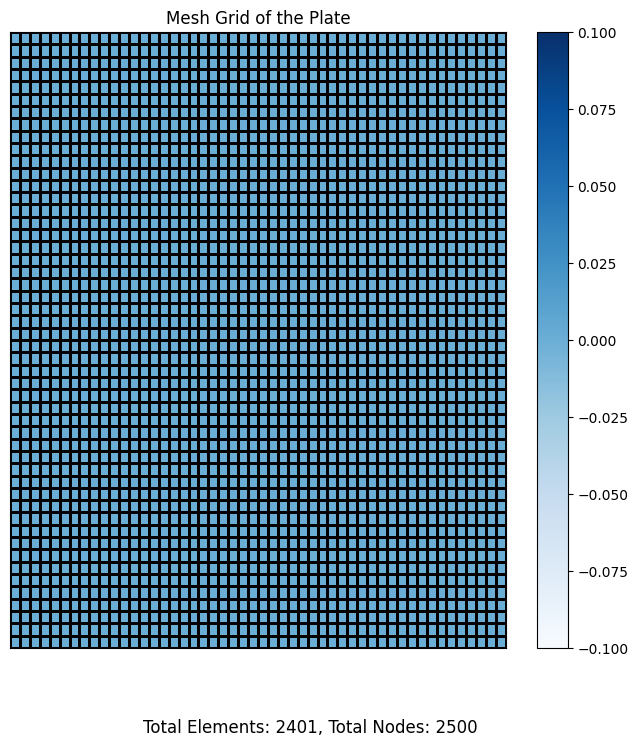

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Lx = 1.0            # Length in the x-direction (meters)
Ly = 1.0            # Length in the y-direction (meters)
Nx = 50             # Number of grid points in the x-direction
Ny = 50             # Number of grid points in the y-direction

# Discretization
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create grid points
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Create the meshgrid
X, Y = np.meshgrid(x, y)

# Plotting the mesh (without temperatures)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mesh Grid of the Plate")
ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

# Displaying the grid lines using pcolormesh (only showing the grid structure)
c = ax.pcolormesh(X, Y, np.zeros_like(X), cmap='Blues', edgecolors='k', linewidth=1)

# Show a colorbar (even though we're not displaying temperature values, it's just for visual enhancement)
fig.colorbar(c, ax=ax)

# Display the total number of elements and nodes
num_elements = (Nx - 1) * (Ny - 1)
num_nodes = Nx * Ny
plt.figtext(0.5, 0.01, f"Total Elements: {num_elements}, Total Nodes: {num_nodes}", ha="center", va="center", fontsize=12)

plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Parameters
Lx = 1.0            # Length in the x-direction (meters)
Ly = 1.0            # Length in the y-direction (meters)
Nx = 50             # Number of grid points in the x-direction
Ny = 50             # Number of grid points in the y-direction

# Discretization
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create grid points
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Create the meshgrid
X, Y = np.meshgrid(x, y)

# Flatten the grid to use for plotly scatter plot
x_flat = X.flatten()
y_flat = Y.flatten()

# Create node numbers for the hover
node_numbers = np.arange(1, len(x_flat) + 1)

# Create a plotly scatter plot of the nodes
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x_flat,
    y=y_flat,
    mode='markers',
    marker=dict(color='blue', size=8, line=dict(width=1, color='black')),
    text=node_numbers,  # Set the node numbers as hover text
    hoverinfo='text',    # Show node number when hovering
))

# Set the layout for the plot
fig.update_layout(
    title="Mesh Grid of the Plate",
    xaxis_title="X (m)",
    yaxis_title="Y (m)",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    plot_bgcolor='white'
)

fig.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Parameters
Lx = 1.0            # Length in the x-direction (meters)
Ly = 1.0            # Length in the y-direction (meters)
Nx = 50             # Number of grid points in the x-direction
Ny = 50             # Number of grid points in the y-direction

# Discretization
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create grid points
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Create the meshgrid
X, Y = np.meshgrid(x, y)

# Total number of elements
total_elements = (Nx - 1) * (Ny - 1)

# Create a plotly figure
fig = go.Figure()

# Add the nodes to the plot
fig.add_trace(go.Scatter(
    x=X.flatten(),
    y=Y.flatten(),
    mode='markers',
    marker=dict(color='blue', size=6),
    text=np.arange(1, Nx * Ny + 1),  # Node numbers for hover
    hoverinfo='text',
    name="Nodes"
))

# Add the finite elements by drawing lines for each grid cell
for i in range(Nx - 1):
    for j in range(Ny - 1):
        # Define the four corners of the cell
        x_coords = [x[i], x[i+1], x[i+1], x[i], x[i]]
        y_coords = [y[j], y[j], y[j+1], y[j+1], y[j]]

        # Add the lines for the cell
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color='black', width=1),
            hoverinfo='skip',  # No hover for element edges
            showlegend=False
        ))

# Set the layout for the plot
fig.update_layout(
    title=f"Mesh Grid of the Plate with Finite Elements<br>Total Elements: {total_elements}",
    xaxis_title="X (m)",
    yaxis_title="Y (m)",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    plot_bgcolor='white'
)

# Show the plot
fig.show()

# Print total number of elements
print(f"Total number of elements: {total_elements}")


Total number of elements: 2401


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Parameters
Lx = 1.0            # Length in the x-direction (meters)
Ly = 1.0            # Length in the y-direction (meters)
Nx = 50             # Number of grid points in the x-direction
Ny = 50             # Number of grid points in the y-direction

# Discretization
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)

# Create grid points
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)

# Create the meshgrid
X, Y = np.meshgrid(x, y)

# Total number of elements
total_elements = (Nx - 1) * (Ny - 1)

# Initialize temperature matrix
T = np.zeros((Ny, Nx))  # (row, col) = (y, x)

# Apply boundary conditions
T[:, 0] = 100  # Left boundary: 100°C
T[:, -1] = 24  # Right boundary: 24°C
# Upper and lower boundaries are insulated (adiabatic), so no temperature changes

# Create a plotly figure
fig = go.Figure()

# Add the nodes to the plot
fig.add_trace(go.Scatter(
    x=X.flatten(),
    y=Y.flatten(),
    mode='markers',
    marker=dict(color='blue', size=6),
    text=np.round(T.flatten(), 2),  # Temperature values as hover text
    hoverinfo='text',
    name="Nodes"
))

# Add the finite elements by drawing lines for each grid cell
for i in range(Nx - 1):
    for j in range(Ny - 1):
        # Define the four corners of the cell
        x_coords = [x[i], x[i+1], x[i+1], x[i], x[i]]
        y_coords = [y[j], y[j], y[j+1], y[j+1], y[j]]

        # Add the lines for the cell
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color='black', width=1),
            hoverinfo='skip',  # No hover for element edges
            showlegend=False
        ))

# Highlight the boundaries
# Left (100°C)
fig.add_trace(go.Scatter(
    x=[0] * Ny,
    y=y,
    mode='markers',
    marker=dict(color='red', size=8),
    name="100°C (Left Boundary)"
))

# Right (24°C)
fig.add_trace(go.Scatter(
    x=[Lx] * Ny,
    y=y,
    mode='markers',
    marker=dict(color='cyan', size=8),
    name="24°C (Right Boundary)"
))

# Upper and Lower (Insulated)
fig.add_trace(go.Scatter(
    x=x,
    y=[0] * Nx,
    mode='lines',
    line=dict(color='green', dash='dash', width=2),
    name="Adiabatic (Lower Boundary)"
))

fig.add_trace(go.Scatter(
    x=x,
    y=[Ly] * Nx,
    mode='lines',
    line=dict(color='green', dash='dash', width=2),
    name="Adiabatic (Upper Boundary)"
))

# Set the layout for the plot
fig.update_layout(
    title=f"Mesh Grid of the Plate with Boundary Conditions<br>Total Elements: {total_elements}",
    xaxis_title="X (m)",
    yaxis_title="Y (m)",
    showlegend=True,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    plot_bgcolor='white'
)

# Show the plot
fig.show()

# Print total number of elements
print(f"Total number of elements: {total_elements}")


Total number of elements: 2401


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Parameters
Lx, Ly = 1.0, 1.0       # Dimensions of the plate (meters)
Nx, Ny = 50, 50         # Number of grid points in x and y directions
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
alpha = 0.0001          # Thermal diffusivity (m^2/s)
dt = 0.25 * min(dx, dy)**2 / alpha  # Time step (stability condition)

# Convergence criteria
epsilon = 1e-6  # Convergence threshold
max_steps = 100000  # Safety limit for maximum simulation steps

# Initial temperature distribution
T = np.full((Ny, Nx), 24.0)  # Entire plate initialized to 24°C
T[:, 0] = 100                # Left boundary at 100°C (heat source)

# Helper function to plot temperature distribution
def plot_temperature(T, title):
    fig = go.Figure(data=go.Contour(
        z=T,
        x=np.linspace(0, Lx, Nx),
        y=np.linspace(0, Ly, Ny),
        colorscale='viridis',
        colorbar=dict(title='Temperature (°C)'),
    ))
    fig.update_layout(
        title=title,
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
    )
    fig.show()

# User input: Simulation time or equilibrium
user_input = input(
    "Enter simulation time in seconds (or press Enter to simulate until equilibrium): "
)

if user_input.strip():
    max_time = float(user_input)  # User-specified simulation time
    num_steps = int(max_time / dt)
    run_until_equilibrium = False
else:
    run_until_equilibrium = True  # Simulate until equilibrium

# Plot the initial temperature profile
plot_temperature(T, title="Initial Temperature Distribution")

# Simulation loop
T_new = T.copy()
time = 0.0
step = 0
converged = False

while (not converged and step < max_steps) or (not run_until_equilibrium and step < num_steps):
    max_delta = 0.0  # Track maximum temperature change

    # Update internal nodes using Explicit FDM
    for i in range(1, Ny - 1):
        for j in range(1, Nx - 1):
            T_new[i, j] = T[i, j] + alpha * dt * (
                (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dy**2 +
                (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dx**2
            )
            max_delta = max(max_delta, abs(T_new[i, j] - T[i, j]))

    # Apply boundary conditions
    T_new[0, :] = T_new[1, :]    # Top boundary (adiabatic)
    T_new[-1, :] = T_new[-2, :]  # Bottom boundary (adiabatic)
    T_new[:, 0] = 100            # Left boundary (constant heat source)
    T_new[:, -1] = T_new[:, -2]  # Right boundary (adiabatic)

    # Check for convergence if running until equilibrium
    if run_until_equilibrium:
        converged = max_delta < epsilon

    # Swap temperature arrays
    T = T_new.copy()

    # Increment time and step count
    time += dt
    step += 1

# Plot the final temperature profile
plot_temperature(T, title=f"Final Temperature Distribution after {time:.2f} seconds")

# Print results
if run_until_equilibrium:
    print(f"Simulation completed. Equilibrium reached in {time:.2f} seconds.")
else:
    print(f"Simulation completed. Total time: {time:.2f} seconds.")


Enter simulation time in seconds (or press Enter to simulate until equilibrium): 


Simulation completed. Equilibrium reached in 40266.56 seconds.
